
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Simulate Monthly Mean Sea Level using a multivariate-linear regression model based on the annual SST PCs

inputs required: 
  * WaterLevel historical data from a tide gauge at the study site 
  * Historical and simulated Annual PCs (*from Notebook 01*)

in this notebook:
  * Obtain monthly mean sea level anomalies (MMSLA) from the tidal gauge record
  * Perform linear regression between MMSLA and annual PCs
  * Obtain predicted timeseries of MMSLA based on simulated timeseries of annual PCs 

### Workflow:

<div>
<img src="resources/nb01_02.png" width="300px">
</div>



Monthly sea level variability is typically due to processes occurring at longer timescales than the daily weather. Slowly varying seasonality and anomalies due to ENSO are retained in the climate emulator via the principle components (APC) used to develop the AWT. A multivariate regression model containing a mean plus annual and seasonal cycles at 12-month and 6-month periods for each APC covariate was fit to the MMSLA. This simple model explains ~75% of the variance without any specific information regarding local conditions (i.e., local anomalies due to coastal shelf dynamics, or local SSTAs) and slightly underpredicts extreme monthly sea level anomalies by ~10 cm. While this component of the approach is a subject of ongoing research, the regression model produces an additional ~0.35 m of regional SWL variability about mean sea level, which was deemed sufficient for the purposes of demonstrating the development of the stochastic climate emulator.

In [68]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
from collections import OrderedDict

# python libs
import numpy as np
import xarray as xr
from scipy.stats import linregress
from scipy.optimize import least_squares, curve_fit
from datetime import datetime, timedelta
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.tides import Calculate_MMSL
from teslakit.statistical import runmean
from teslakit.util.time_operations import date2yearfrac as d2yf

from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL, \
Plot_Validate_MMSL_tseries, Plot_Validate_MMSL_scatter, Plot_MMSL_Prediction, \
Plot_MMSL_Histogram



## Database and Site parameters

In [3]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/anacrueda/Documents/Proyectos/TESLA/data'
db = Database(p_data)

# set site
db.SetSite('MAJURO')

In [4]:
# --------------------------------------
# load data and set parameters

TIDE_gauge, _ = db.Load_TIDE_hist()      # water level historical data (tide gauge)
TIDE = TIDE_gauge.WaterLevel

SST_KMA = db.Load_SST_KMA()              # SST Anual Weather Types PCs
SST_PCs_sim_m = db.Load_SST_PCs_sim_m()  # simulated SST PCs (monthly)

# parameters for mmsl calculation
mmsl_year_ini = 1996
mmsl_year_end = 2017



## Monthly Mean Sea Level

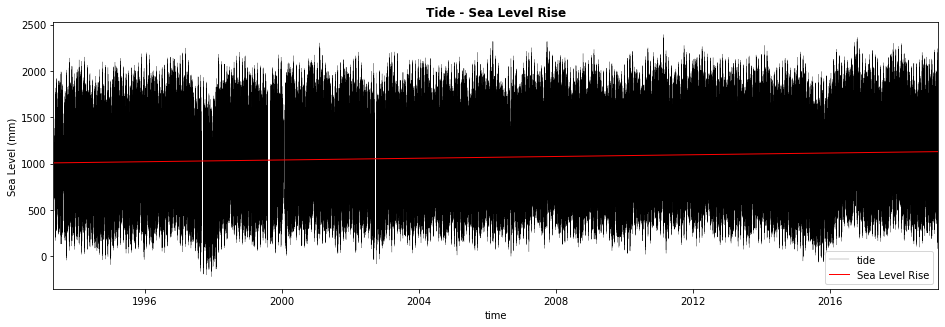

In [6]:
# --------------------------------------
# Calculate SLR using linear regression

time = TIDE.time.values[:]
tide = TIDE.values[:] * 1000  # (m to mm)

lr_time = np.array(range(len(time)))  # for linregress
mask = ~np.isnan(lr_time) & ~np.isnan(tide)
slope, intercept, r_value, p_value, std_err = linregress(lr_time[mask], tide[mask])
slr = intercept + slope * lr_time

# Plot tide with SLR
Plot_Tide_SLR(time, tide, slr);


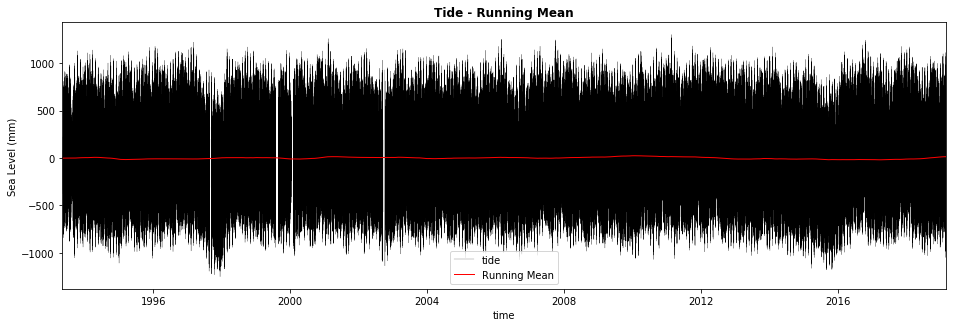

In [7]:
# --------------------------------------
# remove SLR and runmean from tide 

tide_noslr = tide - slr

# calculate tide running mean
time_window = 365*24*3
runm = runmean(tide_noslr, time_window, 'mean')

# remove running mean
tide_noslr_norunm = tide_noslr - runm

# store data 
TNSR = xr.DataArray(tide_noslr_norunm,  dims=('time'), coords={'time':time})


# Plot tide without SLR and runm
Plot_Tide_RUNM(time, tide_noslr, runm);


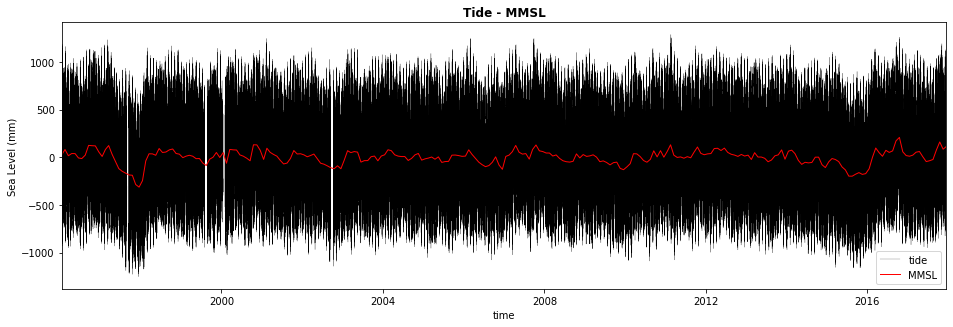

In [8]:
# --------------------------------------
# calculate Monthly Mean Sea Level (mmsl)

MMSL = Calculate_MMSL(TNSR, mmsl_year_ini, mmsl_year_end)
mmsl_time = MMSL.time.values[:]
mmsl_vals = MMSL.mmsl.values[:]

# Plot tide and mmsl 
Plot_Tide_MMSL(TNSR.time, TNSR.values, mmsl_time, mmsl_vals);

# store historical mmsl
db.Save_TIDE_hist_mmsl(MMSL)



## Monthly Mean Sea Level - Principal Components
The annual PCs are passed to a monthly resolution

In [9]:
# --------------------------------------
# SST Anual Weather Types PCs

PCs = np.array(SST_KMA.PCs.values)
PC1, PC2, PC3 = PCs[:,0], PCs[:,1], PCs[:,2]
PCs_years = [int(str(t).split('-')[0]) for t in SST_KMA.time.values[:]]

# MMSL PCs calculations: cut and pad it to monthly resolution
ntrs_m_mean = np.array([])
ntrs_time = []

MMSL_PC1 = np.array([])
MMSL_PC2 = np.array([])
MMSL_PC3 = np.array([])

for c, y in enumerate(PCs_years):
    pos = np.where(
        (mmsl_time >= np.datetime64('{0}-06-01'.format(y))) &
        (mmsl_time <= np.datetime64('{0}-05-29'.format(y+1)))
    )

    if pos[0].size:
        ntrs_m_mean = np.concatenate((ntrs_m_mean, mmsl_vals[pos]),axis=0)
        # TODO check for 0s and nans in ntrs_m_mean?
        ntrs_time.append(mmsl_time[pos])

        MMSL_PC1 = np.concatenate((MMSL_PC1, np.ones(pos[0].size)*PC1[c]),axis=0)
        MMSL_PC2= np.concatenate((MMSL_PC2, np.ones(pos[0].size)*PC2[c]),axis=0)
        MMSL_PC3 = np.concatenate((MMSL_PC3, np.ones(pos[0].size)*PC3[c]),axis=0)

ntrs_time = np.concatenate(ntrs_time)


# Parse time to year fraction for linear-regression seasonality 
frac_year = np.array([d2yf(x) for x in ntrs_time])



## Monthly Mean Sea Level - Multivariate-linear Regression Model

[-2.17298097e+00 -1.66914291e+00  2.05302018e+00 -2.17734662e-02
  1.35721214e+01 -9.58376406e-01  1.66997946e+00 -6.45544115e-01
  2.21252153e+01  1.44238118e+00 -1.56864677e+00  1.45540193e+00
 -2.75817293e+01 -5.10157616e-01  3.18780474e-01  7.04971637e-01
 -3.78630864e+00  2.23767535e-01  2.26299246e-01 -4.02506423e-01]
[[ 9.52370316e+00  2.02593179e-02  1.17840322e-01  1.91841737e-01
  -2.73219956e-01  5.90194073e-03 -1.39189442e-02 -3.54814138e-02
  -4.86666784e-01  2.27296545e-02 -1.25904858e-01 -1.34875292e-01
   8.21006294e-02 -3.69495617e-03  3.09851959e-02  2.31029340e-02
  -2.40986807e-01  1.87170873e-03  1.10482525e-02 -1.26947725e-02]
 [ 2.02593179e-02  1.53062527e-02 -1.73473880e-02 -4.96680006e-03
   5.87569619e-03 -3.73544658e-04  1.29583012e-03  1.50973027e-03
   2.27671424e-02 -1.13420021e-03  4.51469688e-03  5.82223202e-03
  -3.77933928e-03  2.64937140e-04 -8.75722770e-04 -1.01419961e-03
   1.90020657e-03 -2.37235811e-04  5.83991159e-04  5.30712030e-04]
 [ 1.1784032

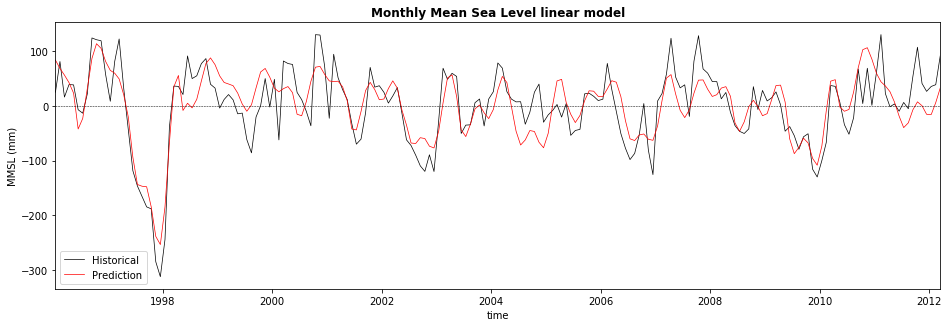

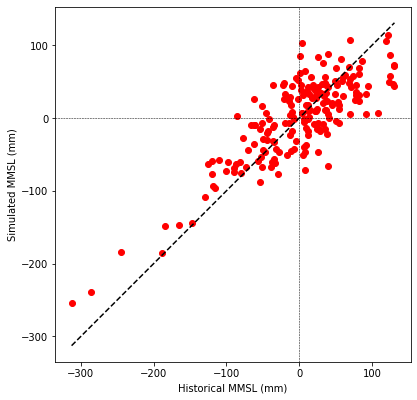

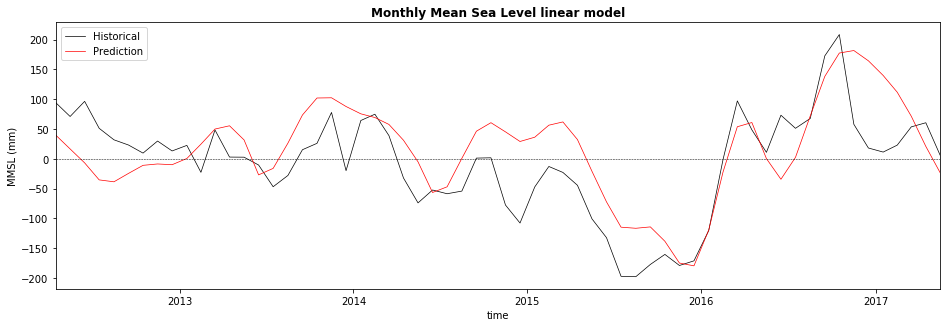

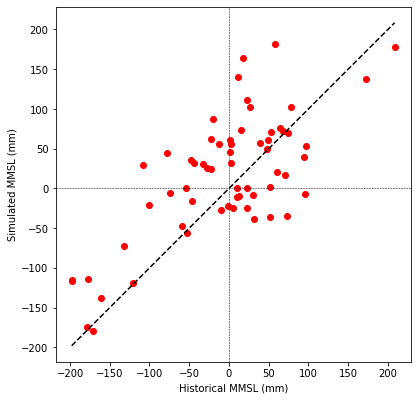

[[-5.94256672e+00 -1.88657533e+00  2.32626389e+00  3.41576304e-01
   1.79647611e+01 -7.91841198e-01  1.92689807e+00 -9.66799642e-01
   2.08626915e+01  1.31115352e+00 -1.95691407e+00  1.33233146e+00
  -1.73891668e+01 -5.27630526e-01 -3.03084463e-02  7.07923649e-01
  -9.64558812e-01  2.35234062e-01  4.32917527e-01 -2.43994752e-02]
 [-2.49581387e+00 -1.62459482e+00  2.73840808e+00  2.68738253e-01
   1.57798574e+01 -8.21328306e-01  1.27620013e+00 -1.14668941e+00
   1.21115906e+01  1.54655448e+00 -1.10359638e+00  1.39352368e+00
  -3.04026516e+01 -5.20294943e-01 -6.88554596e-02  1.89336546e+00
   2.17259863e+00  3.51333102e-01  1.33186805e-01 -1.49101012e+00]
 [-5.20207939e+00 -1.50131155e+00  1.56012990e+00 -1.41240212e-01
   1.72192101e+01 -1.05912717e+00  1.24912507e+00 -7.43249152e-01
   1.90454556e+01  1.33042453e+00 -1.63991353e+00  1.39551939e+00
  -2.20872242e+01 -5.88179148e-01  3.07271135e-01 -1.01270034e-01
  -9.40306485e+00  3.29944044e-01  4.38923878e-01 -6.49604811e-01]
 [-2.49

In [103]:
# --------------------------------------
# Fit linear regression model and obtain covariance matrix of the parameters


def modelfun(data, a, b, c, d, e, f, g, h, i,j, k, l, m, n, o, p, q, r, s, u ):
    pc1, pc2, pc3,t = data
    #a, b, c, d, e, f, g, h, i,j, k, l, m, n, o, p, q, r, s, u = params
    return a + b*pc1 + c*pc2 + d*pc3 + \
           np.array([e + f*pc1 + g*pc2 + h*pc3]).flatten() * np.cos(2*np.pi*t) + \
           np.array([i + j*pc1 + k*pc2 + l*pc3]).flatten() * np.sin(2*np.pi*t) + \
           np.array([m + n*pc1 + o*pc2 + p*pc3]).flatten() * np.cos(4*np.pi*t) + \
           np.array([q + r*pc1 + s*pc2 + u*pc3]).flatten() * np.sin(4*np.pi*t)


split = 195
x0 = np.ones(20)
#x0 = np.array([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]])
#print(x0)
sigma = np.array(np.ones(split))

res_lsq, res_cov = curve_fit(
    modelfun,([MMSL_PC1[:split], MMSL_PC2[:split], MMSL_PC3[:split],frac_year[:split]]),ntrs_m_mean[:split],x0,sigma)

print(res_lsq)
print(res_cov)

# TRAIN AND TEST THE MODEL

# check model at fitting period
y_0s = np.zeros(frac_year.shape)
yp_test = modelfun(([MMSL_PC1[:split], MMSL_PC2[:split], MMSL_PC3[:split],frac_year[:split]]),res_lsq[0],res_lsq[1],res_lsq[2],res_lsq[3], \
                  res_lsq[4],res_lsq[5],res_lsq[6],res_lsq[7],res_lsq[8],res_lsq[9],res_lsq[10],res_lsq[11], res_lsq[12],res_lsq[13],res_lsq[14], \
                  res_lsq[15],res_lsq[16],res_lsq[17],res_lsq[18],res_lsq[19]
                  )
Plot_Validate_MMSL_tseries(ntrs_time[:split], ntrs_m_mean[:split], yp_test);
Plot_Validate_MMSL_scatter(ntrs_m_mean[:split], yp_test);

# check model at validating period
yp_val = modelfun(([MMSL_PC1[split:], MMSL_PC2[split:], MMSL_PC3[split:],frac_year[split:]]),res_lsq[0],res_lsq[1],res_lsq[2],res_lsq[3], \
                  res_lsq[4],res_lsq[5],res_lsq[6],res_lsq[7],res_lsq[8],res_lsq[9],res_lsq[10],res_lsq[11], res_lsq[12],res_lsq[13],res_lsq[14], \
                  res_lsq[15],res_lsq[16],res_lsq[17],res_lsq[18],res_lsq[19]
                  )
Plot_Validate_MMSL_tseries(ntrs_time[split:], ntrs_m_mean[split:], yp_val);
Plot_Validate_MMSL_scatter(ntrs_m_mean[split:], yp_val);

# generate sample of params based on covariance matrix
n_sims = 10
theta_gen = np.array([res_lsq[0],res_lsq[1],res_lsq[2],res_lsq[3], \
                  res_lsq[4],res_lsq[5],res_lsq[6],res_lsq[7],res_lsq[8],res_lsq[9],res_lsq[10],res_lsq[11], res_lsq[12],res_lsq[13],res_lsq[14], \
                  res_lsq[15],res_lsq[16],res_lsq[17],res_lsq[18],res_lsq[19]])
theta_sim = multivariate_normal(theta_gen, res_cov, n_sims)

print(theta_sim)


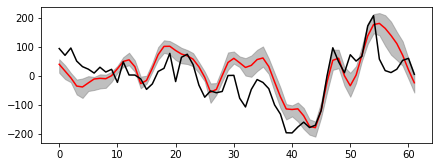

In [106]:
#validation period with parameter sampling

yp_valp = np.ndarray((n_sims,len(ntrs_time[split:]))) * np.nan
for i in range(n_sims):
    yp_valp[i,:] = modelfun(([MMSL_PC1[split:], MMSL_PC2[split:], MMSL_PC3[split:],frac_year[split:]]),theta_sim[i,0],theta_sim[i,1],theta_sim[i,2],theta_sim[i,3], \
                           theta_sim[i,4],theta_sim[i,5],theta_sim[i,6],theta_sim[i,7],theta_sim[i,8],theta_sim[i,9],theta_sim[i,10],theta_sim[i,11],theta_sim[i,12],\
                           theta_sim[i,13],theta_sim[i,14],theta_sim[i,15],theta_sim[i,16],theta_sim[i,17],theta_sim[i,18],theta_sim[i,19])
    #print(yp_valp[i,:])
    
yp_val_quant = np.percentile(yp_valp,[2.275, 97.275],axis=0)

fig = plt.figure(1, figsize=(7, 2.5))
# plot the shaded range of the confidence intervals
plt.fill_between(range(yp_valp.shape[1]), yp_val_quant[0,:], yp_val_quant[1,:],
                     color='grey', alpha=.5)
# plot the mean on top
plt.plot(yp_val, 'red')
#plot the historical
plt.plot(ntrs_m_mean[split:],'black')

In [142]:
# FIT the model with ALL the DATA
sigma = np.array(np.ones(len(frac_year)))
res_lsq, res_cov = curve_fit(
    modelfun,([MMSL_PC1, MMSL_PC2, MMSL_PC3,frac_year]),ntrs_m_mean,x0,sigma)

# generate 1000 simulations of the parameters 
n_sims = 1000
theta_gen = np.array([res_lsq[0],res_lsq[1],res_lsq[2],res_lsq[3], \
                  res_lsq[4],res_lsq[5],res_lsq[6],res_lsq[7],res_lsq[8],res_lsq[9],res_lsq[10],res_lsq[11], res_lsq[12],res_lsq[13],res_lsq[14], \
                  res_lsq[15],res_lsq[16],res_lsq[17],res_lsq[18],res_lsq[19]])
param_sim = multivariate_normal(theta_gen, res_cov, n_sims)
print(param_sim)
# TODO: guardar los parametros para cada simulacion??? 
# Save model parameters
#model_coefs = xr.Dataset({'sim_params' : (('n_params'), res_lsq.x)})
#db.Save_TIDE_mmsl_params(model_coefs)


[[-2.04750087 -1.90278943  1.32417407 ...  0.23037096  0.18617931
  -0.31058338]
 [-4.81325533 -1.75898301  1.48353969 ...  0.14168501  1.17154386
  -0.13468993]
 [-6.29829189 -1.63493136  1.28953975 ...  0.02340406  0.70745605
  -0.08317707]
 ...
 [-3.24040959 -1.79385353  1.43294073 ...  0.11723557  0.46964654
   0.18811805]
 [-5.42858488 -1.74765995  1.3928898  ...  0.32578756  0.51205759
  -1.26565912]
 [-4.14395409 -1.64878174  1.32141559 ...  0.37455223  0.08870206
  -0.84361695]]


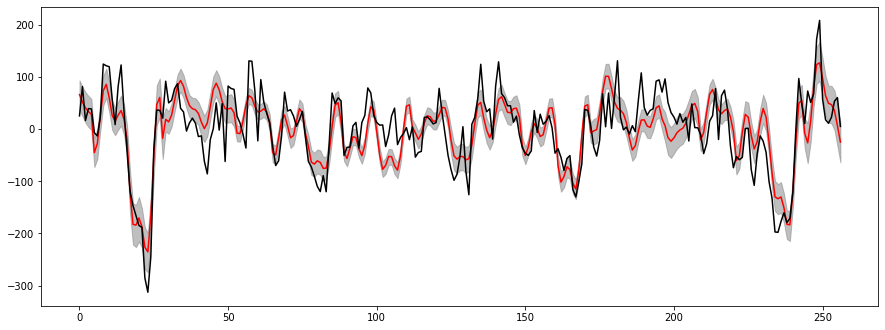

In [154]:

yp_val = modelfun(([MMSL_PC1, MMSL_PC2, MMSL_PC3,frac_year]),res_lsq[0],res_lsq[1],res_lsq[2],res_lsq[3], \
                  res_lsq[4],res_lsq[5],res_lsq[6],res_lsq[7],res_lsq[8],res_lsq[9],res_lsq[10],res_lsq[11], res_lsq[12],res_lsq[13],res_lsq[14], \
                  res_lsq[15],res_lsq[16],res_lsq[17],res_lsq[18],res_lsq[19]
                  )


yp_valp = np.ndarray((n_sims,len(ntrs_time))) * np.nan
for i in range(n_sims):
    yp_valp[i,:] = modelfun(([MMSL_PC1, MMSL_PC2, MMSL_PC3,frac_year]),param_sim[i,0],param_sim[i,1],param_sim[i,2],param_sim[i,3], \
                           param_sim[i,4],param_sim[i,5],param_sim[i,6],param_sim[i,7],param_sim[i,8],param_sim[i,9],param_sim[i,10],param_sim[i,11],param_sim[i,12],\
                           param_sim[i,13],param_sim[i,14],param_sim[i,15],param_sim[i,16],param_sim[i,17],param_sim[i,18],param_sim[i,19])
    #print(param_sim[i,0])
    
yp_val_quant = np.percentile(yp_valp,[2.275, 97.275],axis=0)
#print(yp_val_quant)
fig = plt.figure(1, figsize=(15, 5.5))
# plot the shaded range of the confidence intervals
plt.fill_between(range(yp_valp.shape[1]), yp_val_quant[0,:], yp_val_quant[1,:],
                     color='grey', alpha=.5)
# plot the mean on top
plt.plot(yp_val, 'red')
#plot the historical
plt.plot(ntrs_m_mean,'black')



## Monthly Mean Sea Level - Prediction

In [146]:
# --------------------------------------
# Predict 1000 years using simulated PCs (monthly time resolution)

# get simulation time as year fractions
PCs_sim_time = SST_PCs_sim_m.time.values[:]
frac_year_sim = np.array([d2yf(x) for x in PCs_sim_time])

# solve each PCs simulation
l_MMSL_sim = []
for s in SST_PCs_sim_m.n_sim:
    
    PCs_s_m = SST_PCs_sim_m.sel(n_sim=s)
    MMSL_PC1_sim = PCs_s_m.PC1.values[:]
    MMSL_PC2_sim = PCs_s_m.PC2.values[:]
    MMSL_PC3_sim = PCs_s_m.PC3.values[:]
    theta_sim = param_sim[s,:]
    
    # use linear-regression model
    y_0s = np.zeros(frac_year_sim.shape)
    y_sim = modelfun(([MMSL_PC1_sim, MMSL_PC2_sim, MMSL_PC3_sim,frac_year_sim]),theta_sim[0],theta_sim[1],theta_sim[2],theta_sim[3], \
                           theta_sim[4],theta_sim[5],theta_sim[6],theta_sim[7],theta_sim[8],theta_sim[9],theta_sim[10],theta_sim[11],theta_sim[12],\
                           theta_sim[13],theta_sim[14],theta_sim[15],theta_sim[16],theta_sim[17],theta_sim[18],theta_sim[19])
 
    # append simulated MMSL
    l_MMSL_sim.append(
        xr.Dataset(
            {
                'mmsl' : (('time',), y_sim / 1000),  # mm to m
            },
            {'time' : PCs_sim_time}
        )
    )
    
# concatenate simulations
MMSL_sim = xr.concat(l_MMSL_sim, 'n_sim')
print(MMSL_sim)

db.Save_TIDE_sim_mmsl(MMSL_sim)


<xarray.Dataset>
Dimensions:  (n_sim: 100, time: 12012)
Coordinates:
  * time     (time) object 1999-06-01 00:00:00 ... 3000-05-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    mmsl     (n_sim, time) float64 0.02083 0.0006307 ... 0.04855 0.0493


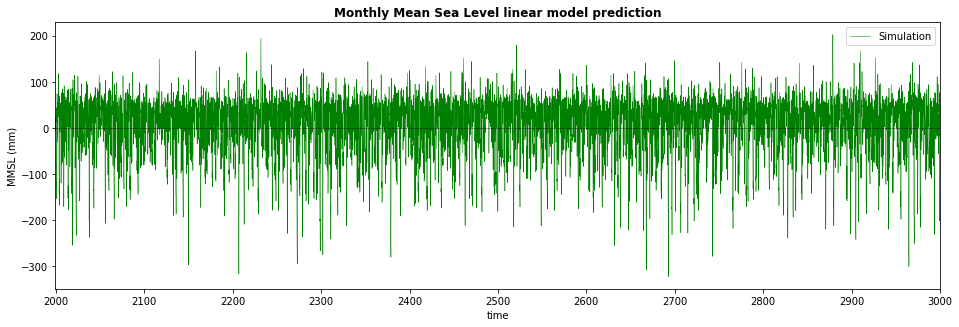

[ 20.82978678   0.63066851  -7.5676897  ...  35.17510844  97.08156686
 114.56636385]


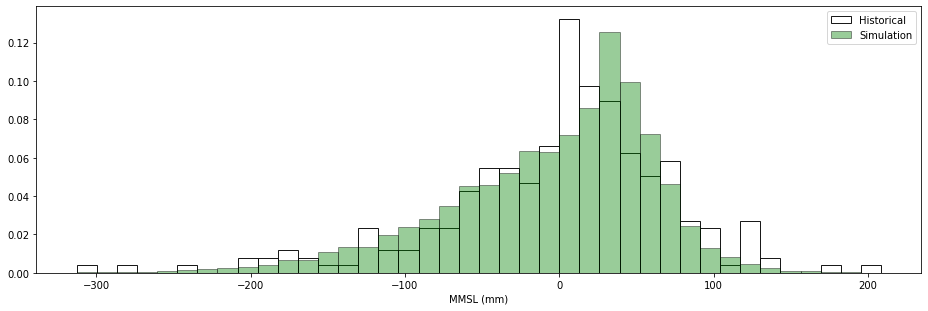

In [147]:
# Plot mmsl simulation 

plot_sim = 0

y_sim = MMSL_sim.sel(n_sim=plot_sim).mmsl.values[:] * 1000  # m to mm
t_sim = MMSL_sim.sel(n_sim=plot_sim).time.values[:]

# Plot mmsl prediction
Plot_MMSL_Prediction(t_sim, y_sim);

y_sim_all = np.ndarray((len(SST_PCs_sim_m.n_sim),len(t_sim))) * np.nan
for s in SST_PCs_sim_m.n_sim:
    y_sim_all[s,:] = MMSL_sim.sel(n_sim=plot_sim).mmsl.values[:] * 1000  # m to mm
    
print(y_sim_all.flatten())
# compare model histograms
Plot_MMSL_Histogram(ntrs_m_mean, y_sim_all.flatten());


In [148]:
print(np.max(y_sim_all.flatten()))

202.42103952945152


In [155]:
print(np.min(y_sim_all.flatten()))

-323.0372724704957
